In [1]:
from utils.CoopEnv import CoopEnv
from utils.IACagent import Agent

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# Set constant hyperparameters
n = 10
num_of_tasks  = 5
num_of_sims = 1
step_limit = 10000

In [4]:
lower_bound = 0.01
upper_bound = 2.00
comm_array = np.arange(lower_bound, upper_bound+0.01, 0.01)

comm_space = len(comm_array)
print(comm_array)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

In [5]:
env = CoopEnv(n=n, num_of_tasks=num_of_tasks)

In [6]:
steps_to_complete = np.zeros((num_of_sims, step_limit+1))
comm_rec_actions = np.zeros((step_limit, env.n))
move_rec_actions = np.zeros((step_limit, env.n))
rec_rewards = np.zeros((step_limit, env.n))

agentlist = {i: Agent(comm_space, alr=2e-4, vlr=6e-4 ) for i in range(env.n)}

In [7]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        # reset the environment
        observations = env.reset(n=n, num_of_tasks =num_of_tasks)

        # begin training loop
        t = 0
        while t < step_limit:
            print(t, end='\r')

            # collect move action for each agent
            move_action = np.array([agentlist[i].choose_action_move(observations[i]) for i in range(env.n)])

            next_observations, context = env.step1(move_action)

            comm_action = np.array([agentlist[i].choose_action_comm(context[i]) for i in range(env.n)])
            comm_action = comm_array[comm_action]

            rewards = env.step2(comm_action) # env.step

            comm_rec_actions[t] = comm_action  # output from actor (comm head)
            move_rec_actions[t] = move_action

            for i in range(env.n): # train each agent
                action = np.array([move_action[i], comm_action[i]])
                singleton_val = env.singleton_vals[f'Player {i+1}']
                agentlist[i].train(observations[i], action, rewards[i], next_observations[i], context[i], singleton_val)

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t+1] = sum(rewards)/env.n
            rec_rewards[t, :] = rewards

            # increment timestep and loop
            t +=1


In [8]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------


In [9]:
# save reward and actions
converged_structure = np.zeros((num_of_tasks, env.n))
task = 0
for C in env.CS:
    indices = [int(a)-1 for a in list(C)]
    converged_structure[task, indices] = 1
    task+=1

np.save(f'n{n}t{num_of_tasks}_cum_rew_bc', steps_to_complete)
np.save(f'n{n}t{num_of_tasks}_actions_bc', comm_rec_actions)
np.save(f'n{n}t{num_of_tasks}_cstruct_cnf0.npy', converged_structure)

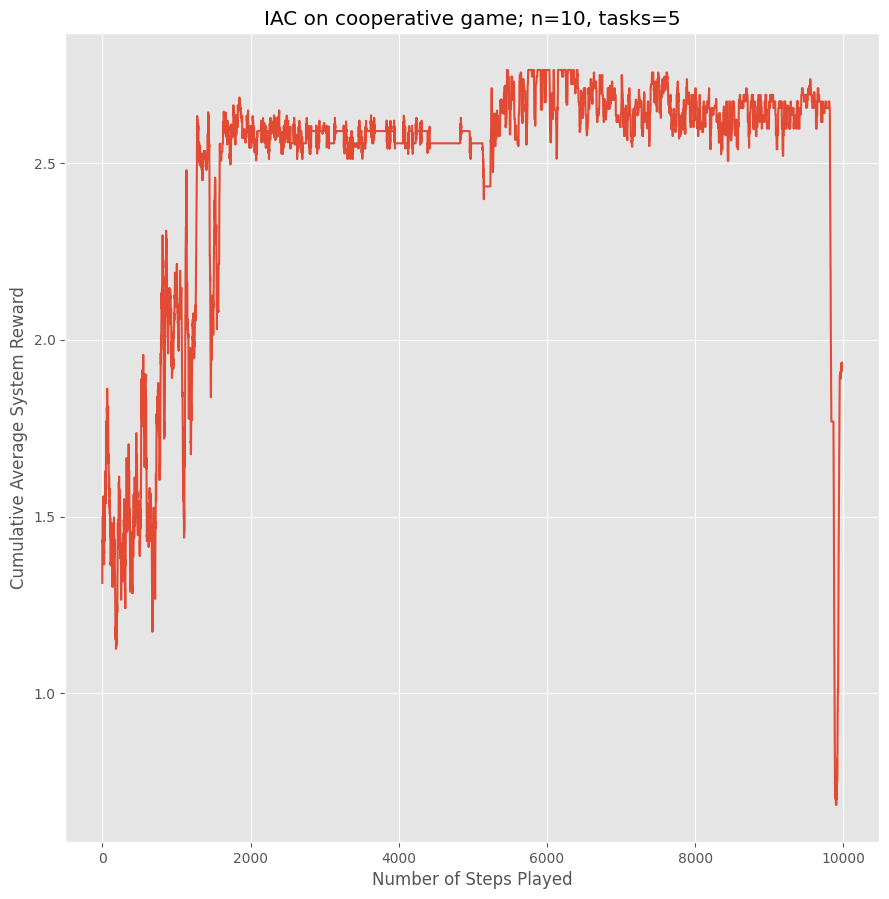

In [18]:
plt.style.use('ggplot')
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)

def moving_average(arr, window_size):
    moving_averages = []
    for i in range(len(arr) - window_size + 1):
        window = arr[i:i + window_size]
        average = sum(window) / window_size
        moving_averages.append(average)
    return moving_averages

plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Average System Reward')
plt.title(f'IAC on cooperative game; n={n}, tasks={num_of_tasks}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(moving_average(b,20))

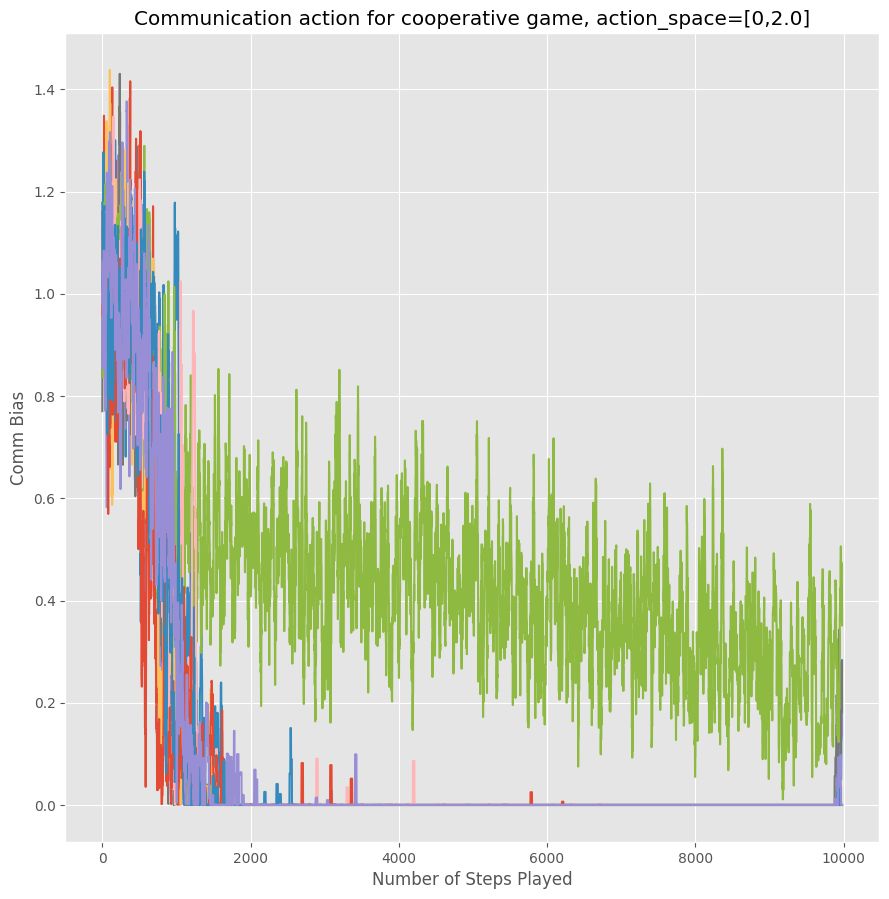

In [19]:
plt.xlabel('Number of Steps Played')
plt.ylabel('Comm Bias')
plt.title(f'Communication action for cooperative game, action_space=[{lower_bound},{upper_bound}]')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

plt.plot(moving_average(comm_rec_actions,20))

[{'1', '10', '5', '7', '8', '4'}, {'9', '2'}, {'6'}, set(), {'3'}]


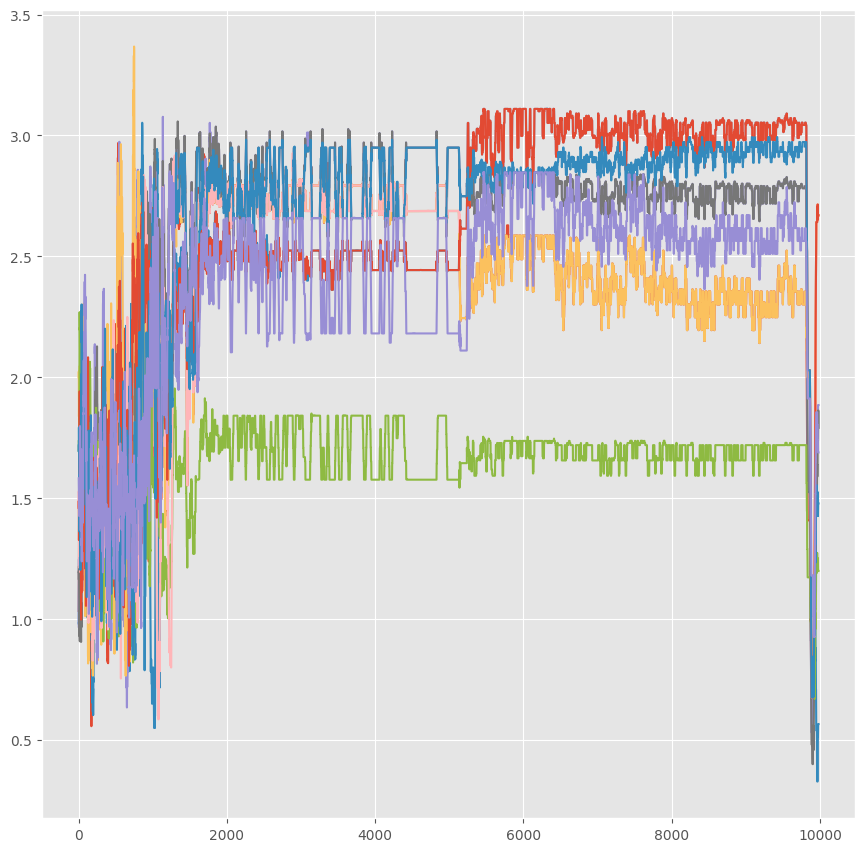

In [20]:
print(env.CS)
for j in range(env.n):
    plt.plot(moving_average(rec_rewards[:,j], 20))

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)